<a href="https://colab.research.google.com/github/laggyperson/URAP-Colab-ML-Notebooks/blob/main/Traffic_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # Experiment
# # Will split the inputs and labels of the features based on initial parameters
# def split_window(features):
#   inputs = features[:, slice(0, 7), :]
#   labels = features[:, slice(8, 10), :]

#   # Slicing doesn't preserve static shape information, so set the shapes
#   # manually. This way the `tf.data.Datasets` are easier to inspect.
#   inputs.set_shape([None, 7, None])
#   labels.set_shape([None, 2, None])

#   return (inputs, labels)

# data = []
# count = 1
# for _ in range(50):
#   data.append(np.array([count]))
#   count += 1

# data = np.array(data)

# ds = keras.utils.timeseries_dataset_from_array(
#         data=data,
#         targets=None,
#         sequence_length=10,
#         sequence_stride=5,
#         shuffle=False,)

# for feature in ds.take(1):
#   print(np.array(feature))

# ds = ds.map(split_window)

# # for feature, label in ds.take(1):
# #   print(np.array(feature), "=>", np.array(label))

# Preprocessing Head

Since I have 550 time series data, there will be 550 numeric preprocessing heads because every times series has their own mean and standard deviation.

In [ ]:
# Creating inputs
inputs = {}
categorical_vars = ["Traffic Light State", "Destination Edge", "Destination Reached"] # Last one is binary, but is "y" and "n", so will convert it

for label in all_xarr["Data Labels"].data:
  dtype = tf.float32
  if label in categorical_vars:
    dtype = tf.string
  inputs[label] = keras.Input(shape=(1, ), name=label, dtype=dtype)

In [ ]:
# Checking this time series
single_ts.data.shape

(1320550, 22)

In [ ]:
# Handling numerical columns
# Putting together numeric input layers
numeric_inputs = {label:input for label, input in inputs.items() if input.dtype==tf.float32}

# Concatenating the layers
temp = layers.Concatenate()(list(numeric_inputs.values()))

norm = layers.Normalization()
norm.adapt(single_ts.sel({"Data Labels": list(numeric_inputs.keys())}).data.astype(float))

In [ ]:
all_numeric_inputs = norm(temp)

In [ ]:
# Categorical variables
cat_vars = [] # (# of categorical vars)
for label in categorical_vars:
  # Will only need to use one time series for creating this: more efficient (I believe)
  lookup = layers.StringLookup(vocabulary=np.unique(all_xarr.sel({"Data Labels":label}).data))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
  reshape = layers.Concatenate()

  tmp = lookup(inputs[label])
  tmp = one_hot(tmp)
  cat_vars.append(tmp)

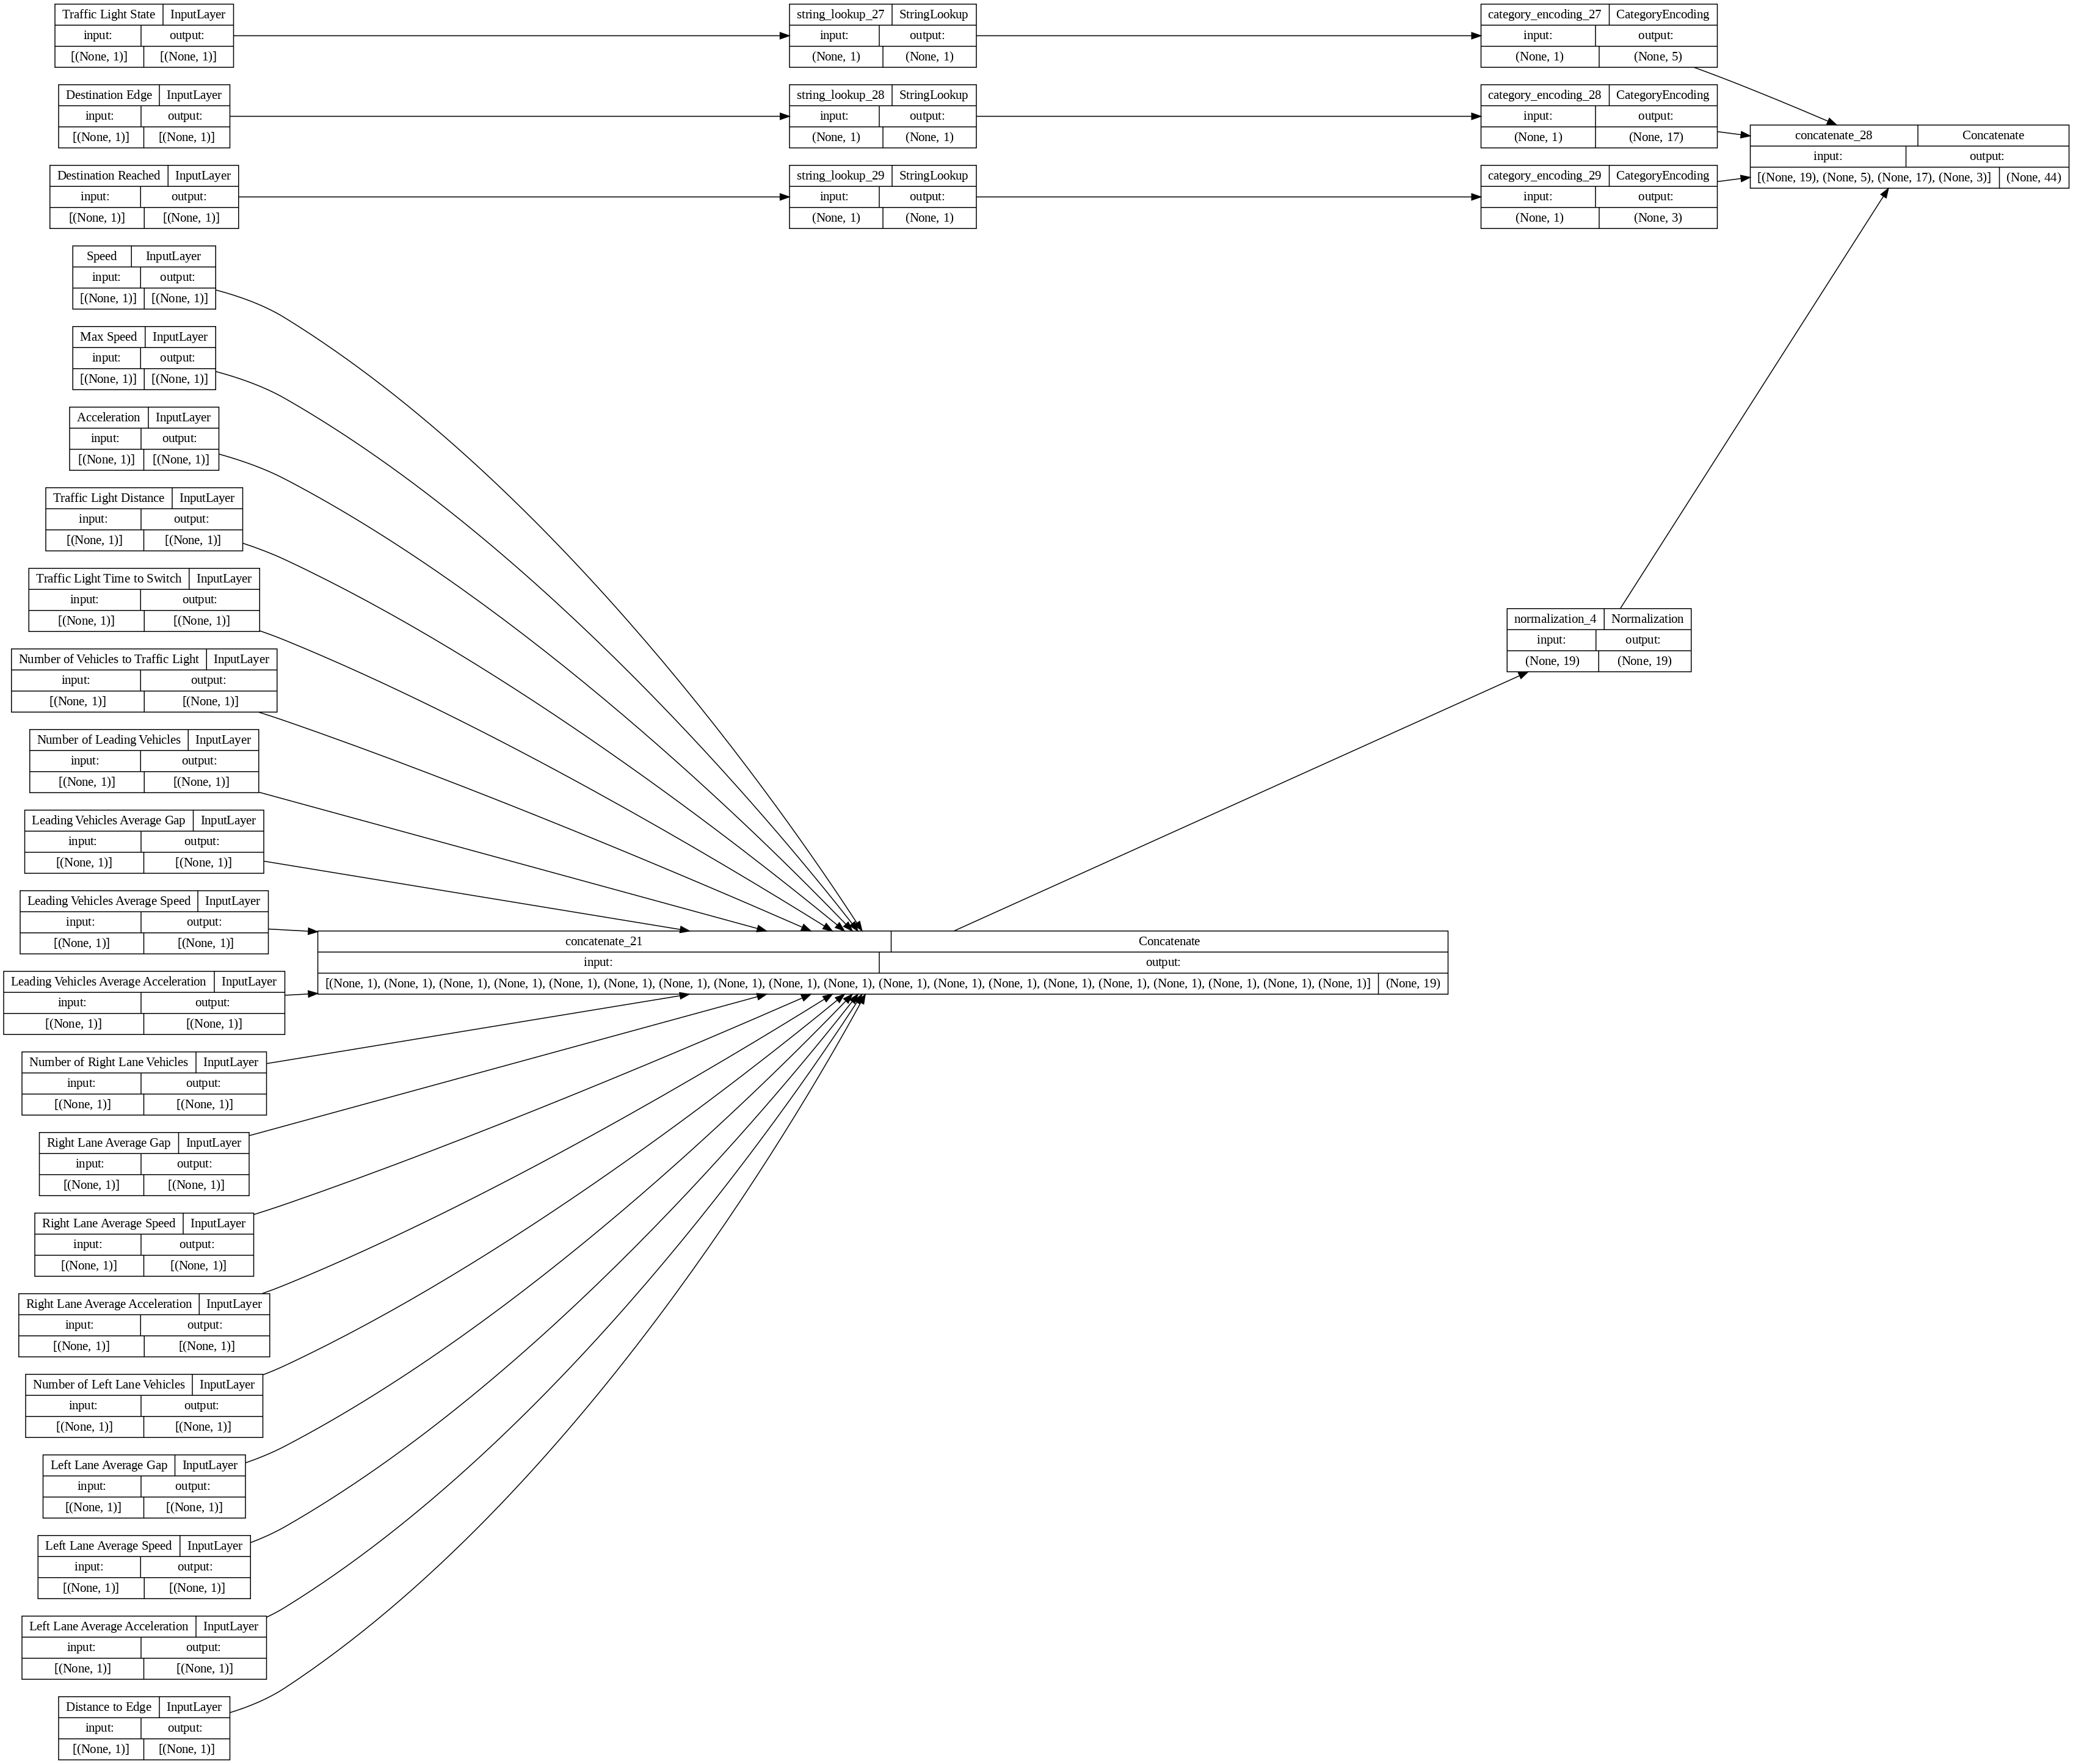

In [ ]:
# Creating the processing heads
preprocessing_list = [all_numeric_inputs] + cat_vars
preprocessing_cat = layers.Concatenate()(preprocessing_list)
preprocessing_head = keras.Model(inputs, preprocessing_cat)

# Printing one out to check structure
tf.keras.utils.plot_model(model=preprocessing_head, rankdir="LR", dpi=108, show_shapes=True)

In [ ]:
# Saving the model
preprocessing_head.save("/content/drive/MyDrive/Colab Notebooks/preprocessing_head.keras")

# About
These are the models/experiments I will be running on the Sumo collected data.

Idea on Data:
* https://stats.stackexchange.com/questions/305863/how-to-train-lstm-model-on-multiple-time-series-data
* https://datascience.stackexchange.com/questions/67171/can-i-use-lstm-models-to-evaluate-multiple-independent-time-series
* https://medium.com/@kavyamalla/extending-tensorflows-window-generator-for-multiple-time-series-8b15eba57858

## Idea 1:
Seems like I batch together multiple vehicles and train it through the entire series. Then to test within the cycle, run a partial window through new vehicles and check the labels??

## Idea 2:
I am collecting data into `(# of vehicles across all simulations, # of time steps, data)`. I originally was normalizing according to each vehicle, but I don't think I should do that since the relative amount of traffic should be learned by normalizing across all simulation data.

I will then create the normal preprocessing head and then combine that into a model with a compile function. There will be no processing beforehand.

To further organize the data, I will split the data into 70% training, 20% validation, and 10% test. This means the first 70% of the time series data is used, so on so forth.

The way the data is organized is as follows:
Say each vehicle in each simulation has a time series that looks like
$[f_0, ..., f_{2401}]$ where $f_i$ is a vector of all the features at a certain time step.

Say that my window is 50 time steps total, split into 25 inputs and 25 labels.
$$[0, ..., 24] \rightarrow [25, ...,49]$$
If I take a stride of 25 and batch 32 sequences together, the data will look as follows:

**Batch 1:**

$[f_0, ..., f_{24}] \rightarrow [f_{25}, ..., f_{49}]$

$[f_{25}, ..., f_{49}] \rightarrow [f_{50}, ..., f_{74}]$

$\qquad \qquad \qquad \vdots$

$[f_{775}, ..., f_{799}] \rightarrow [f_{800}, ..., f_{824}]$

**Batch 2:**

$[f_{800}, ..., f_{824}] \rightarrow [f_{825}, ..., f_{849}]$

$\qquad\qquad\qquad \vdots$

**Batch 3:**

$\vdots$

After shuffling, each `input, label` pair will be shuffled around. The state of the LSTM will be reset after each batch.

This data will be normalized all together, so there is a sense of relative amounts of traffic that differs in every simulation

##Issue:
An issue that needs to be addressed is the changing destinations. It is possible that the LSTM will become confused when in the middle of an input the car suddenly switches a destination, meaning the model suddenly has to disregard the previous destination and its associated values.

### Idea 1:
Split the vehicle time series data into separate sequences that end when the vehicle reaches the destination. This would lead to variable window and input lengths that will not be padded because the lengths may vary a lot.

### Idea 2:
Batch the data the same way as before, but remove any inputs where the destination changes. Filtering the data seems to be possible.

In [65]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [66]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

# Loading the Data

In [67]:
g16_100v_noLC_shortTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_noLC.nc")
g16_100v_noLC_shortTL_arr = g16_100v_noLC_shortTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_100v_LC_shortTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_LC.nc")
g16_100v_LC_shortTL_arr = g16_100v_LC_shortTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_100v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_100v_LC_longTL.nc")
g16_100v_LC_longTL_arr = g16_100v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_50v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_50v_LC_longTL.nc")
g16_50v_LC_longTL_arr = g16_50v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_200v_LC_longTL_ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/Data/G16_200v_LC_longTL.nc")
g16_200v_LC_longTL_arr = g16_200v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

# List of all arrays
arrs = [g16_100v_noLC_shortTL_arr, g16_100v_LC_shortTL_arr, g16_100v_LC_longTL_arr, g16_50v_LC_longTL_arr, g16_200v_LC_longTL_arr]

In [68]:
# Concatenating
all_xarr = xr.concat(arrs, dim="Veh IDs")

In [69]:
# Offloading RAM since arrs not needed anymore
del g16_100v_noLC_shortTL_ds
del g16_100v_noLC_shortTL_arr
del g16_100v_LC_shortTL_ds
del g16_100v_LC_shortTL_arr

del g16_100v_LC_longTL_ds
del g16_100v_LC_longTL_arr

del g16_50v_LC_longTL_ds
del g16_50v_LC_longTL_arr

del g16_200v_LC_longTL_ds
del g16_200v_LC_longTL_arr

del arrs

# Preprocessing
Faster than preprocessing head

In [71]:
categorical_vars = ["Traffic Light State", "Destination Edge", "Destination Reached"] # Last one is binary, but is "y" and "n", so will convert it
numeric_vars = [label for label in all_xarr["Data Labels"].data if label not in categorical_vars]

In [72]:
# New label order
labels = numeric_vars + categorical_vars

In [189]:
# Getting numerical data into correct shape
single_ts = all_xarr.sel({"Data Labels": numeric_vars}).data.astype(float)
single_ts = np.concatenate(single_ts)

# Data to Normalize
numerical_data = all_xarr.sel({"Data Labels": numeric_vars}).data.astype(float)

In [190]:
# Getting rid of bad values from Distance to Edge
temp = single_ts[:, -1]
temp[temp < 0] = 0

temp = numerical_data[:, :, -1]
temp[temp < 0] = 0

In [191]:
# Preprocessing manually
num_mean = np.mean(single_ts, axis=0)
num_std = np.std(single_ts, axis=0)
numerical_data = (numerical_data - num_mean) / num_std

In [ ]:
# Loading all categorical data into separate arrays
categorical_data_TL_state = all_xarr.sel({"Data Labels": "Traffic Light State"}).data
categorical_data_dest = all_xarr.sel({"Data Labels": "Destination Edge"}).data
categorical_data_reached = all_xarr.sel({"Data Labels": "Destination Reached"}).data

cat_dict = {
    "Traffic Light State": categorical_data_TL_state,
    "Destination Edge": categorical_data_dest,
    "Destination Reached": categorical_data_reached
}

In [ ]:
# Encoding all the data
for label in categorical_vars:
  curr_arr = cat_dict[label]
  vocab = np.unique(curr_arr)
  encode = layers.StringLookup(vocabulary=vocab, output_mode="one_hot")
  encodings = encode(vocab).numpy()
  trans_dict = {vocab[i]: encodings[i] for i in range(len(vocab))}

  new_arr = []
  for ts in curr_arr:
    new_arr.append(np.array([trans_dict[w] for w in ts]))
  cat_dict[label] = np.array(new_arr)

In [ ]:
print(cat_dict["Traffic Light State"].shape)

(550, 2401, 5)


In [ ]:
# Recombining all categorical data data
categorical_data = np.concatenate(list(cat_dict.values()), axis=-1)
categorical_data.shape # The final dimension will be (TL State, Destination Edge, Destination Reached)

(550, 2401, 25)

In [ ]:
# Recombining all data into a single numpy array
all_data = np.concatenate((numerical_data, categorical_data), axis=-1)
all_data.shape # CHecking proper shape

(550, 2401, 44)

In [ ]:
# Splitting the Data into training and test sets
# Distribution: 70% training, 20% validation, 10% test

steps = len(all_data[0])
# Slices
train_slice = slice(0, int(0.7 * steps))
validate_slice = slice(int(0.7 * steps), int(0.9 * steps))
test_slice = slice(int(0.9 * steps), None)
# Splitting each individual set
slice_func = lambda data, s: data[s]
train_ts = all_data[:, train_slice, :]
validate_ts = all_data[:, validate_slice, :]
test_ts = all_data[:, test_slice, :]

In [ ]:
print(train_ts.shape, validate_ts.shape, test_ts.shape)

(550, 1680, 44) (550, 480, 44) (550, 241, 44)


In [ ]:
# Clearing RAM
del categorical_data_TL_state
del categorical_data_reached
del categorical_data_dest
del cat_dict
del all_xarr
del curr_arr
del encode
del encodings
del label
del new_arr
del num_mean
del num_std
del numerical_data
del categorical_data
del ts
del vocab
del single_ts
del all_data
del categorical_vars
del numeric_vars
del numerical_data_2D
del steps

# Windowing + Batching

In [ ]:
# Creating a Window class

class WindowGenerator():
  def __init__(self, input_width, label_width, shift, stride,
               train_data, val_data, test_data, all_labels, label_columns=None):
    # Windows intialized with data
    self.train_data = train_data
    self.val_data = val_data
    self.test_data = test_data

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.stride = stride

    self.all_labels = all_labels
    if label_columns is not None:
      self.plot_column_indices = {label_columns[i]: i for i in range(len(label_columns))}
    self.label_column_indices = {all_labels[i]: i for i in range(len(all_labels))}
    self.label_columns = label_columns if label_columns is not None else all_labels

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    self.count = 0

  def split_window(self, features):
    inputs = features[:, self.input_slice, :] # (batch, time, data)
    labels = features[:, self.labels_slice, :]
    labels = tf.stack(
        [labels[:, :, self.label_column_indices[name]] for name in self.label_columns],
        axis=-1) # For if only specific features used

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def stack_windows(self, *windows):
    features = tf.concat([w[0] for w in windows], 0)
    labels = tf.concat([w[1] for w in windows], 0)
    return (features, labels)

  def make_cohort(self, data):
    ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32)
    ds = ds.map(self.split_window)
    return ds

  def make_dataset(self, data):
    dss = tuple(self.make_cohort(data[i]) for i in range(len(data)))
    ds = tf.data.Dataset.zip(dss)
    ds = ds.map(self.stack_windows)
    ds = ds.unbatch()
    ds = ds.shuffle(50)
    ds = ds.batch(32)
    ds = ds.prefetch(1)
    return ds

  def plot(self, model=None, plot_col='Distance to Edge', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.plot_column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.plot_column_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time (s)')

  @property
  def train(self):
    return self.make_dataset(self.train_data)

  @property
  def val(self):
    return self.make_dataset(self.val_data)

  @property
  def test(self):
    return self.make_dataset(self.test_data)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.test))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
# Testing windows + batching
w0 = WindowGenerator(40, 40, 40, 40, train_ts[:100], validate_ts[:100], test_ts[:100], labels, ["Destination Reached", "Distance to Edge"])

In [ ]:
test_ds = w0.test
train_ds = w0.train
val_ds = w0.val

# Model Template

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, train, validate, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=validate,
                      callbacks=[early_stopping])
  return history

In [ ]:
OUTPUT_STEPS = 40
num_features = 2

# Model #1: Simple LSTM, Single-Shot Prediction

In [ ]:
simple_lstm = keras.Sequential([
    layers.LSTM(32, return_sequences=False),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(OUTPUT_STEPS * num_features,
                 kernel_initializer=tf.initializers.zeros()),
    layers.Reshape([OUTPUT_STEPS, num_features])
])

In [ ]:
# Adding preprocessing head
history = compile_and_fit(simple_lstm, train_ds, val_ds)

Epoch 1/20
5004/5004 [==============================] - 280s 53ms/step - loss: 0.5215 - mean_absolute_error: 0.0584 - val_loss: 0.9975 - val_mean_absolute_error: 0.0624
Epoch 2/20
5004/5004 [==============================] - 266s 51ms/step - loss: 0.5155 - mean_absolute_error: 0.0522 - val_loss: 0.9981 - val_mean_absolute_error: 0.0637
Epoch 3/20
5004/5004 [==============================] - 262s 50ms/step - loss: 0.5117 - mean_absolute_error: 0.0521 - val_loss: 0.9986 - val_mean_absolute_error: 0.0675


In [ ]:
simple_lstm.evaluate(test_ds)

507/507 [==============================] - 21s 12ms/step - loss: 1.1587 - mean_absolute_error: 0.0727


[1.1587363481521606, 0.07272329926490784]

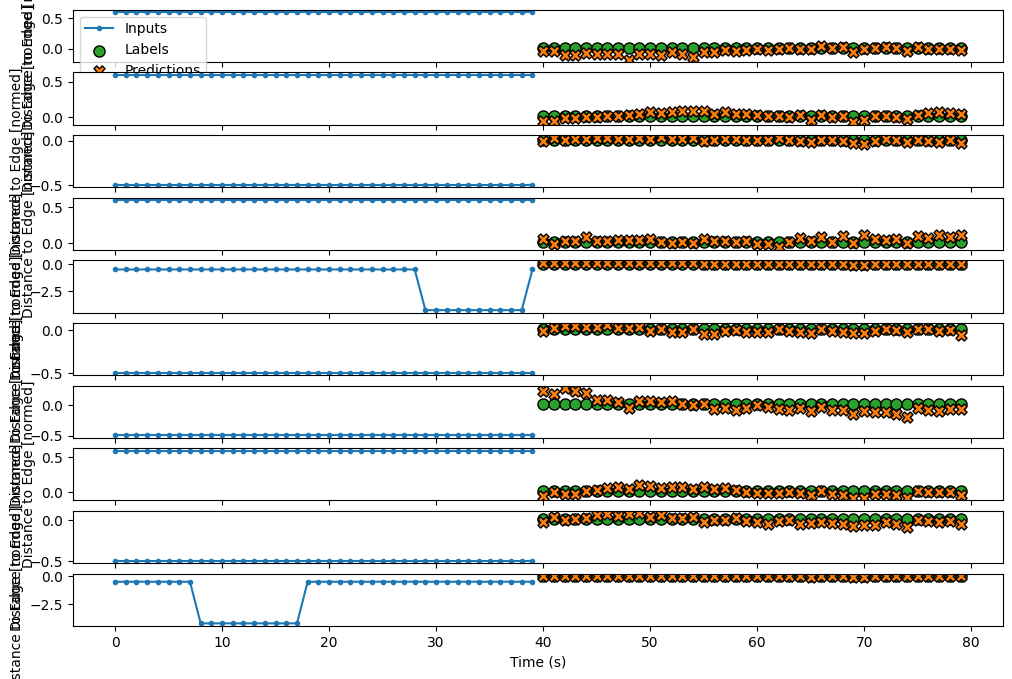

In [ ]:
w0.plot(simple_lstm, plot_col="Distance to Edge", max_subplots=10)

# Model #2: Simple LSTM, Autoregressive Prediction

# Model #3: Denser LSTM, Single-Shot Prediction

# Model #4: Denser LSTM, Autoregressive Prediction

# Model #5: Transformer